In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils
import pickle
from scipy.stats import gaussian_kde
from tqdm import tqdm
import os

mpl.rcParams['figure.dpi'] = 100

datapath = "data/"
figpath = "fig/"
if not os.path.isdir(figpath):
    os.mkdir(figpath)

%load_ext autoreload
%autoreload 2

In [2]:
# Use optimized angle for ICDF
df = pd.read_csv(datapath + "means-europe.csv", skiprows=20)
# Drop self sufficiency; not needed for this notebook
df.drop("suff", axis = 1)

# Drop nans if any
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)


# Compute weights according to latitude
lat_weights = np.array(np.cos(2*np.pi*df.lat / 360))
df["lat_weights"] = lat_weights

# Load icdfs
with open(datapath + "icdf-daily-suff-europe.pickle", "rb") as f:
    d = pickle.load(f)
    qs = d["quantiles"].copy()
    icdfs = d["icdf"]
    d = None # remove ref to d

In [3]:
lat_weights = np.array(np.cos(2*np.pi*df.lat / 360))
df["lat_weights"] = lat_weights
df_s = utils.subsample_df(df, 0.5)
len(icdfs), len(df)

(265543, 265543)

# ICDF analysis

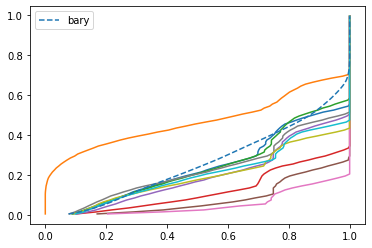

In [4]:
for i in np.random.choice(len(icdfs), 10):
    plt.plot(icdfs[i], qs)
# Compute weighted barycenter
#bary = np.average(icdfs, axis = 0)
bary = np.sum(icdfs * lat_weights.reshape(-1, 1), axis = 0) / lat_weights.sum()
plt.plot(bary, qs, ls = "--", label = "bary")
plt.legend()
plt.show()

In [5]:
# Perform weighted PCA
A = (icdfs - bary.reshape(1, -1)) * lat_weights.reshape(-1, 1)
U, s, Vh = np.linalg.svd(A, full_matrices=False)
# Rescale U so that we can recover the full original icdfs
U /= lat_weights.reshape(-1, 1)

In [6]:
# Change sign of s
U[:,[0]] *= -1
Vh[[0],:]*= -1

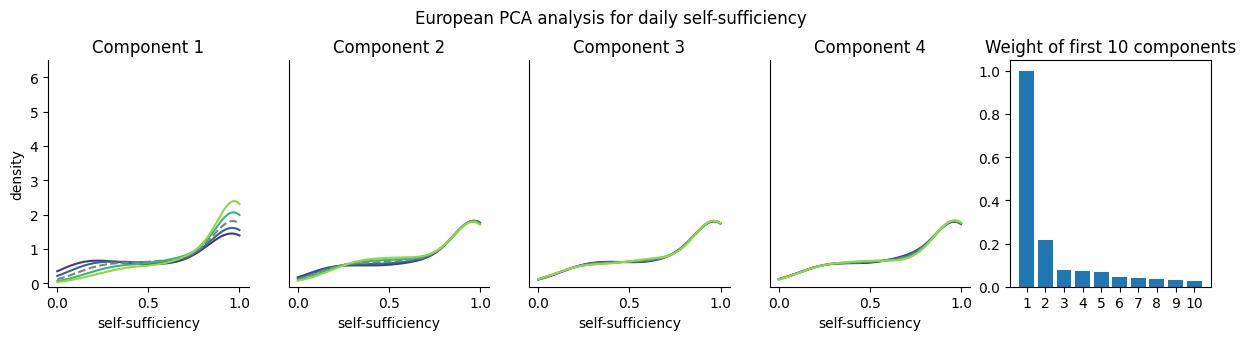

In [7]:
Ncomp = 4
density = True
x = np.linspace(0, 1, 200)
cmap = plt.cm.viridis

fig, axs = plt.subplots(1, Ncomp+1, figsize = (15,3), dpi = 100)
for i in range(Ncomp):
    axs[i].spines[['right', 'top']].set_visible(False)

    v = Vh[i,:]
    # Change sign manually
    a = 0.5*np.std(np.abs(U[:,i]*s[i]))
    for j, da in enumerate(np.linspace(-2, 2, 5)*a):
        ax = axs[i]
        z = bary + da*v
        if density: 
            kernel = gaussian_kde(z)
            y = kernel(x)
            kwargs = dict(color = cmap((da/a + 3)/6) )
            if da == 0:
                kwargs = dict(color = "gray", ls = "--")
            ax.plot(x,y,**kwargs)
            ax.set_ylim([-0.1,6.5])
            axs[0].set_ylabel("density")
        else:
            ax.plot(z,qs, color = cmap((da/a + 3)/6))
            axs[0].set_ylabel("quantile")
        ax.set_xlabel("self-sufficiency")
        ax.set_title(f"Component {i+1}")
        if i > 0:
            ax.set_yticks([])
    ax.set_ylim(axs[0].get_ylim())
ax = axs[-1]

ax.bar(range(1,11), s[:10] / s[0])
ax.set_title("Weight of first 10 components")
ax.set_xticks(range(1,11))
plt.suptitle("European PCA analysis for daily self-sufficiency", y = 1.05)
plt.savefig(figpath + "principal-components-suff-eu.pdf", bbox_inches = "tight")

# Clustering in suff

In [8]:
df_s = utils.subsample_df(df, 0.5)

In [9]:
# Computational part
# For reproducibility
np.random.seed(10)
Nclusters = 3
Ncomp = 1

datai = np.array(df.suff).reshape(-1, 1)

# Renormalize subsampled data
datai_s = np.array(df_s.suff).reshape(-1, 1)
# No need to scale data since it is 1-dimensional and properly normalized between 0 and 1
# Number of KMeans trials
N_trials = 100
results_clustering = dict()
best_score = np.inf

# Try KMeans several times and keep best
for i in tqdm(range(N_trials)):
    index_init = np.random.choice(len(df_s), Nclusters, replace = False)

    _, c, _ = utils.KMeans(datai_s, K = Nclusters, Niter = 20, index_init = index_init, 
                            weights = np.array(df_s.lat_weights),  p = 2)
    D_ij = ((datai_s.reshape(-1, 1, Ncomp) -  c.reshape(1, -1, Ncomp))** 2).sum(-1)
    score = D_ij.min(-1).sum()
    if score < best_score:
        best_score = score
        best_c = c

100%|██████████| 100/100 [00:00<00:00, 238.16it/s]


Total representatives 400


/tmp/ipykernel_1389826/3242084156.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  st = df_c.to_latex(index = False)


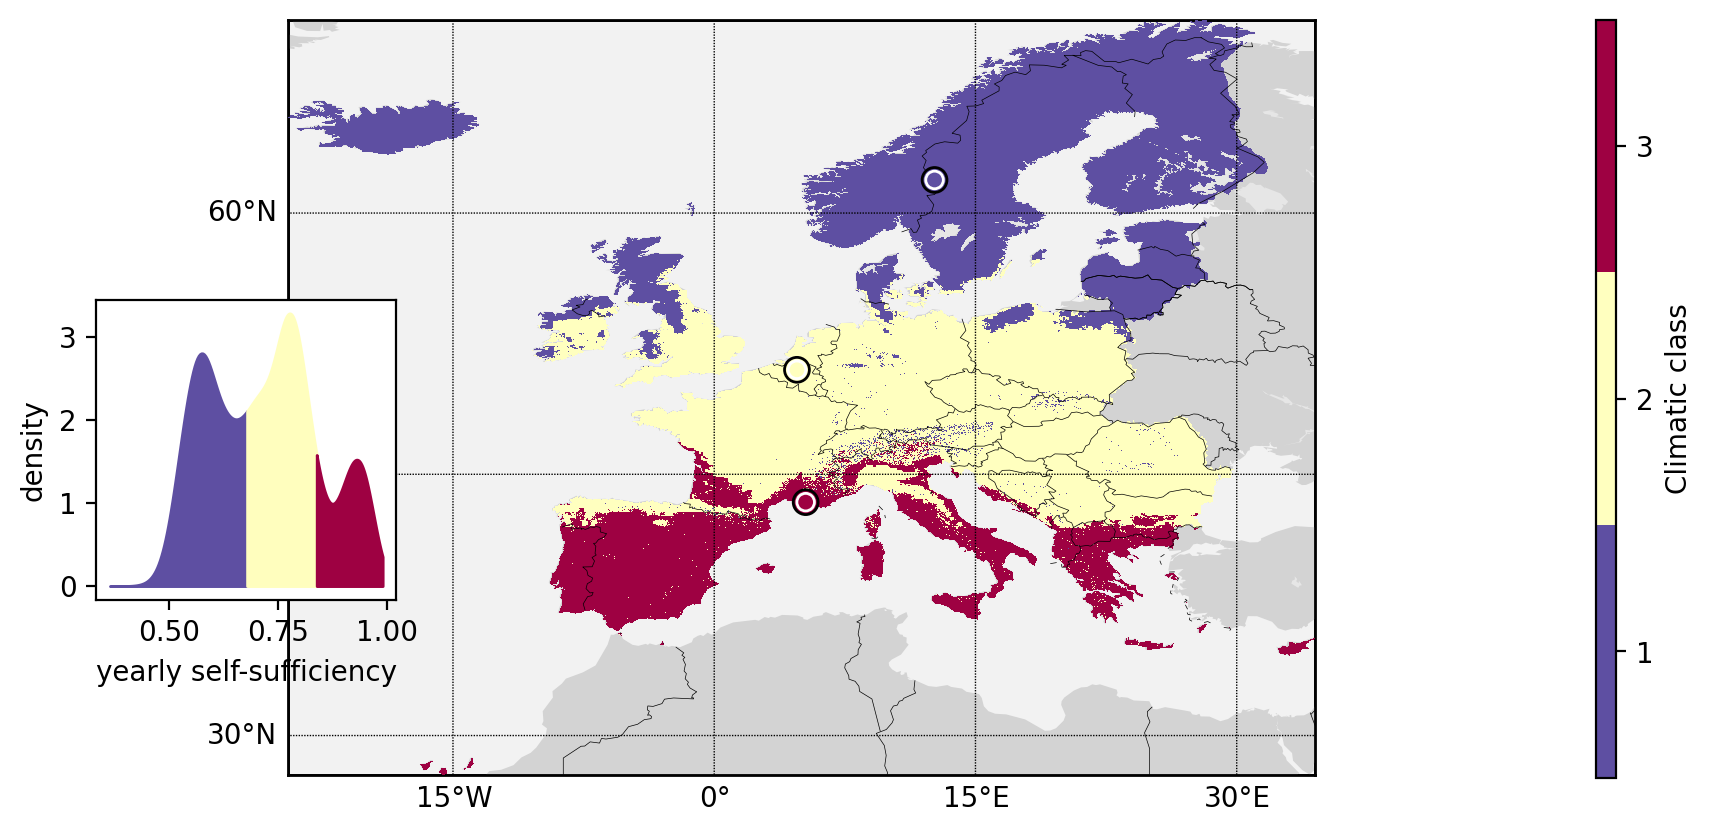

In [12]:
write_tex_table = True
savefig = True

# Plotting part
figs = 20
# Plot distribution of suff
kernel = gaussian_kde(datai_s.ravel())

fig, ax = plt.subplots(figsize = (10,5), ncols = 1, dpi = 200)

c_id_sort = np.argsort(best_c.ravel())
c = best_c[c_id_sort]

cl = ((datai.reshape(-1, 1, Ncomp) - c.reshape(1, -1, Ncomp))**2).sum(-1).argmin(axis=1).reshape(-1) 
ind = utils.random_representatives(datai, c, tol=0.0001)

ax.set_rasterization_zorder(1.5)
coords = df.lat.min(), df.lat.max(), df.lon.min(), df.lon.max()
ax = utils.drawmap(ax, coords, projection = "cyl", step_grid = 15, basemap_res = "l")

cmap = plt.cm.get_cmap("Spectral_r", Nclusters)
# cmap = "turbo"
clim = (0,1)
img, extents = utils.rasterize(df.lat, df.lon, cl+1)
ims = plt.imshow(img, origin = "lower", cmap = cmap, extent = extents,
        interpolation = "nearest", zorder = 3, clim = (0.5, Nclusters+0.5))

ax.scatter(df.lon[ind], df.lat[ind], c = cmap(np.arange(Nclusters)), marker = "o", edgecolor = "k", linewidth = 1, s = 80, zorder = 100)
ax.scatter(df.lon[ind], df.lat[ind], c = cmap(np.arange(Nclusters)), marker = "o", edgecolor = "w", linewidth = 1, s = 40, zorder = 200)

if write_tex_table:
    # Create a df
    df_c = np.hstack((
        np.arange(Nclusters).reshape(-1, 1)+1,
        np.array(df.lat[ind]).reshape(-1, 1),
        np.array(df.lon[ind]).reshape(-1, 1),
        np.array(df.suff[ind]).reshape(-1, 1),
        ))
    df_c = pd.DataFrame(np.round(df_c,3), columns = ["class", "lat", "lon", "suff"])
    st = df_c.to_latex(index = False)
    st = st.replace(".0 &", " &")
    with open(figpath + "centroids_suff-eu.tex", "w") as f:
        f.write(st)

subax = fig.add_axes([0.16,0.30,0.15, 0.3])
for i in range(Nclusters):
    datai_part = datai[cl==i]
    x = np.linspace(np.min(datai_part), np.max(datai_part), 100)
    y  = kernel(x)
    subax.fill_between(x, y, color = plt.cm.Spectral_r(i/(Nclusters-1)))
# subax.scatter(datai, np.zeros_like(datai), c = cl, s = 5, cmap = cmap, edgecolor = "none")
subax.set_xlabel("yearly self-sufficiency")
subax.set_ylabel("density")

# Classification bar
clax = fig.add_axes((0.91,0.122, 0.01, 0.758))
plt.colorbar(ims, cax = clax)
clax.set_ylabel("Climatic class")
clax.set_yticks(np.arange(1,Nclusters+1))

plt.show()


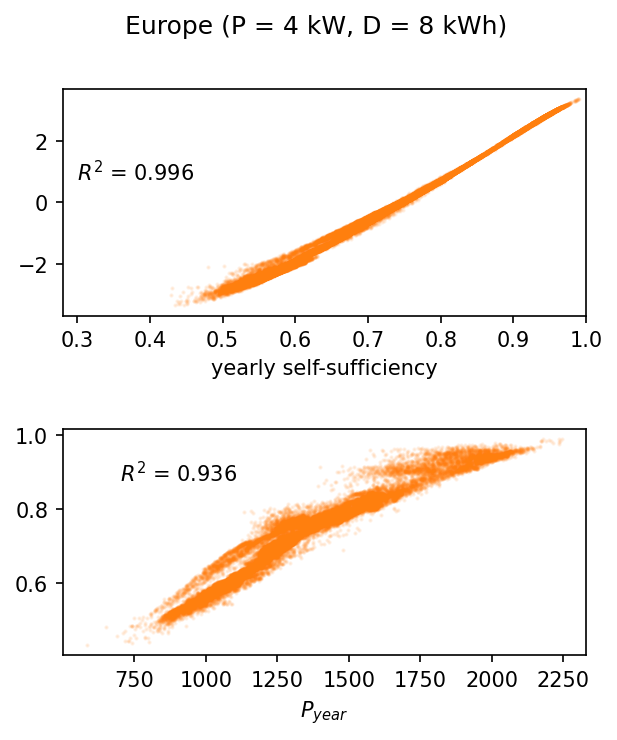

In [11]:
plt.figure(figsize = (4.5,5), dpi = 150)
plt.subplot(211)
plt.suptitle("Europe (P = 4 kW, D = 8 kWh)")
plt.scatter(df.suff[::5], U[::5,0]*s[0], s = 1, alpha = 0.1, color = "tab:orange")

R2 = utils.compute_R2(df.suff, U[:,0]*s[0], weights = lat_weights)
plt.text(0.3, 1, f"$R^2$ = {R2:.3f}",
         va = "center", ha = "left")
plt.xlabel("yearly self-sufficiency")
# plt.ylabel("first principal component")
plt.xlim([0.28, 1.0])
plt.gca().set_rasterization_zorder(1.5)
plt.subplot(212)
plt.scatter(df.E[::10], df.suff[::10], s = 1, alpha = 0.1, color = "tab:orange")

plt.subplots_adjust(hspace = 0.5)
plt.xlabel("$P_{year}$")
# plt.ylabel("yearly self-sufficiency")
R2 = utils.compute_R2(df.E, df.suff, weights = lat_weights)
plt.text(700,0.9, f"$R^2$ = {R2:.3f}",
         va = "center", ha = "left")
# plt.xlim([0.12, 0.8])

plt.gca().set_rasterization_zorder(1.5)
plt.savefig(figpath + "correlation-suff-eu.pdf", bbox_inches = "tight")